### Домашнее задание "Сегментация и детекция объектов"

Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Чтение данных, разбивка на трейн и валидацию 

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
train_label = train[:, 0]

In [4]:
train = train[:, 1:]

In [5]:
from sklearn.model_selection import train_test_split

train_img, val_img, train_lbl, val_lbl = train_test_split(train, train_label, test_size=0.2, random_state=146)

In [21]:
train_img.shape

(33600, 784)

#### Предобработка, нормализация данных

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_img)
train_img = scaler.transform(train_img)
val_img = scaler.transform(val_img)

#### Снижение размерности с применением РСА 

In [8]:
from sklearn.decomposition import PCA
pca = PCA(.95)

In [9]:
pca.fit(train_img)

PCA(n_components=0.95)

In [10]:
train_img_reduced = pca.transform(train_img)
val_img_reduced = pca.transform(val_img)

In [22]:
train_img_reduced.shape

(33600, 318)

Количество параметров уменьшено более чем вдвое (784->318), при этом сохраняется 95% объясненной дисперсии

#### Логистическая регрессия на преобразованных данных

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

In [13]:
lr.fit(train_img_reduced, train_lbl)

LogisticRegression(max_iter=1000)

In [14]:
predicted = lr.predict(val_img_reduced)

In [15]:
predicted

array([3., 3., 7., ..., 2., 5., 5.])

In [16]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(val_lbl, predicted))

Accuracy: 0.9230952380952381


#### Попробуем другие классификаторы

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [27]:
classifiers = {
    'knn': KNeighborsClassifier(n_neighbors=10),
    'svc': SVC(kernel='linear'),
    'sgd': SGDClassifier(max_iter=1000),
    'tree': DecisionTreeClassifier(),
    'rf': RandomForestClassifier()
}

In [28]:
for label, classifier in classifiers.items():
    classifier.fit(train_img_reduced, train_lbl)
    predicted = classifier.predict(val_img_reduced)
    print(label)
    print('Accuracy: %s' % accuracy_score(val_lbl, predicted))
    

knn
Accuracy: 0.9373809523809524
svc
Accuracy: 0.9329761904761905


C:\Users\Polina.DESKTOP-UGBOPLJ\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


sgd
Accuracy: 0.9057142857142857
tree
Accuracy: 0.8065476190476191
rf
Accuracy: 0.929404761904762


Лучший результат из имеющихся показал алгоритм KNN. Возможно, получится еще немного поднять accuracy за счет подбора гиперпараметров

In [29]:
from sklearn.model_selection import GridSearchCV

In [41]:
params={
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'n_neighbors': [5, 10, 15]
}

In [42]:
grid_knn = GridSearchCV(classifiers['knn'], params)

In [43]:
grid_knn.fit(train_img_reduced, train_lbl) 

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=10),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [5, 10, 15],
                         'weights': ['uniform', 'distance']})

In [44]:
print(f'Best score {grid_knn.best_score_} with estimator {grid_knn.best_estimator_}')

Best score 0.9412202380952381 with estimator KNeighborsClassifier(weights='distance')


In [48]:
grid_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}

In [45]:
best_knn = grid_knn.best_estimator_

После подбора гиперпараметров точность на валидационной выборке выросла до ~0,94

#### Предсказание на тестовых данных

In [49]:
test_reduced = pca.transform(test)

In [50]:
test_pred = best_knn.predict(test_reduced)

In [51]:
test_img = np.resize(test, (test.shape[0], 28, 28))

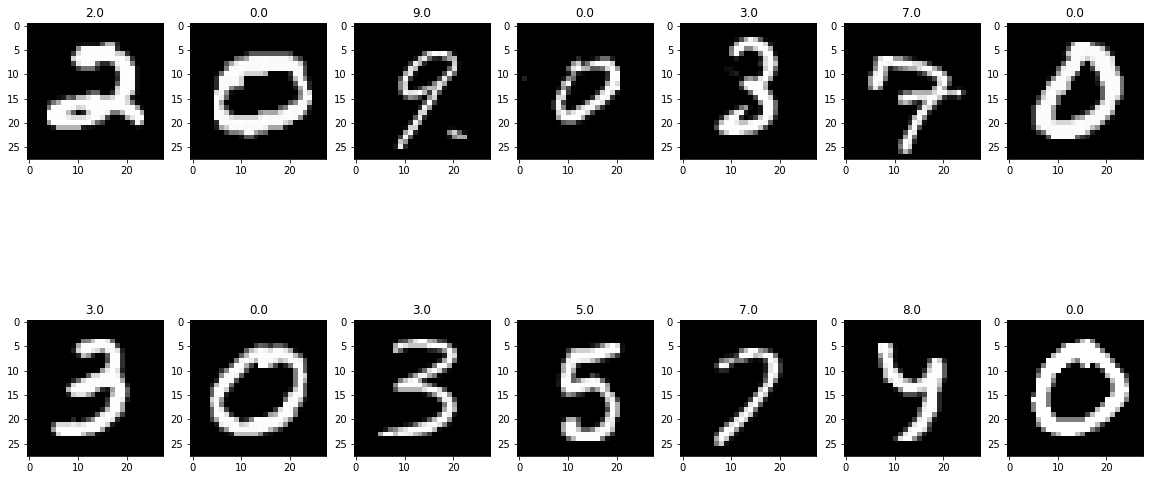

In [52]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:14], 1):
    subplot = fig.add_subplot(2, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % test_pred[i - 1]);

In [59]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(test_pred.astype(int), 1):
        dst.write('%s,%s\n' % (i, p))

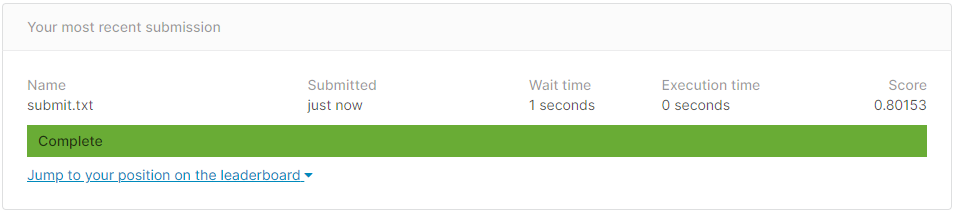

In [60]:
from IPython.display import Image
Image('score.jpg')